In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets

In [2]:
ids = np.load("../../data/spike_clusters.npy")
binned_spikes = np.load("../../data/binned_20ms.npy")
spike_data =  pd.DataFrame(binned_spikes)
spike_data

,0,1,2,3,4,5,6,7,8,9,...,161525,161526,161527,161528,161529,161530,161531,161532,161533,161534
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
stim_on_time = np.load("../../data/natImsOnTimes.npy")
stim_on_time.shape
#to bin: divide by 20, floor

(1500, 1)

In [16]:
np.min(np.diff(stim_on_time, axis=0))

0.6164096894409852

(array([450., 509., 282., 129.,  57.,  29.,  22.,  11.,   7.,   3.]),
 array([0.61640969, 0.81312193, 1.00983416, 1.2065464 , 1.40325864,
        1.59997087, 1.79668311, 1.99339534, 2.19010758, 2.38681982,
        2.58353205]),
 <BarContainer object of 10 artists>)

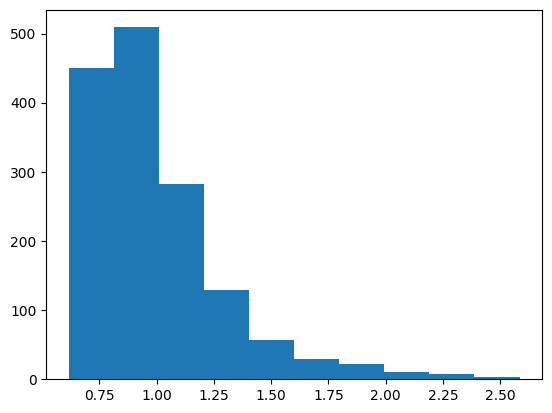

In [15]:
plt.hist(np.diff(stim_on_time, axis=0))

In [3]:
allen = pd.read_csv("../../data/allen_visual_behavior_firing_rate.csv")
allen = allen.iloc[::400]


In [4]:
x = spike_data.columns[0:25].to_list()
y = spike_data.iloc[:,0:25].sum().to_list()


In [5]:
def slope_viz_neurons(t=0):
    t = int(t)
    if t<25:
        x = spike_data.columns[0:25].to_list()
        y = spike_data.iloc[:,0:25].sum().to_list()
    else:
        x = spike_data.columns[t-50:t+50].to_list()
        y = spike_data.iloc[:,t-50:t+50].sum().to_list()
    plt.scatter(x, y, label='Spikes')
    plt.axvline(t, color='red', linestyle='--',)
    plt.xlabel('Time(in 20ms bins)')
    plt.ylabel('Num Spikes')
    plt.legend()
    plt.show()
    print(len(x))
    print(len(y))

probably smoother to have the line move than to have the entire graph move, maybe pass in edges of the graphs as parameters?
def add more widget functions to the ui to clean it up
need to combine with image dataset, maybe transparent boxes or something?
should data be put into bigger bins?

In [6]:
slider = widgets.FloatSlider(value=0.0, min=0.0, max=500.0, step=5.0, description='Time')
slider.layout.width = "100%"
widgets.interact(slope_viz_neurons, t=slider)

interactive(children=(FloatSlider(value=0.0, description='Time', layout=Layout(width='100%'), max=500.0, step=…

<function __main__.slope_viz_neurons(t=0)>